# Predicción de Precios de Coches Usados - Modelo de Machine Learning

## Análisis y procesamiento de datos

### Introduccion
La estimación del precio de un coche de segunda mano es un problema complejo, ya que depende de múltiples factores como el año, el kilometraje, la marca y otras características del vehículo. Para abordar esta tarea, se ha recopilado un conjunto de datos con ventas históricas de coches usados, incluyendo el precio real de venta. A partir de esta información, se aplicarán técnicas de Machine Learning para analizar y procesar los datos, entrenar modelos predictivos y evaluar su desempeño, con el objetivo de sugerir precios en portales de compraventa online o realizar tasaciones automáticas.

### Objetivo
Desarrollar e implementar un modelo de aprendizaje supervisado capaz de predecir el precio de venta de coches de segunda mano, evaluando su desempeño mediante el error absoluto medio (MAE) en el conjunto de validación, considerando satisfactorio un MAE inferior a 3,000 €, con el fin de generar predicciones precisas útiles para la tasación automática o la sugerencia de precios en portales de compraventa online.

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date


# Scikit-learn

import sklearn.preprocessing as prep
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

from joblib import dump

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)



## Cargar datos
En este proyecto utilizaremos Pandas y NumPy para la manipulación y análisis de datos, Matplotlib y Seaborn para la visualización gráfica, y Scikit-Learn para el desarrollo y evaluación de los modelos de machine learning.

In [2]:

train_data = pd.read_csv("data/dataset_coches_train.csv")
test_data = pd.read_csv("data/dataset_coches_test.csv")

print(f"\n Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f" Dimensiones del conjunto de prueba: {test_data.shape}")


 Dimensiones del conjunto de entrenamiento: (4960, 11)
 Dimensiones del conjunto de prueba: (2672, 11)


## 1. Explorar datos iniciales
Informacion General de los datos

En primer lugar a ver qué información contiene el conjunto de datos : el tamaño,filas y columnas , si hay registros duplicados o ausentes, etc.

In [3]:

print("============== Primeras 5 filas ================")
print(train_data.head()) 
print("============= Últimas 5 filas ====================")
print(train_data.tail())

============== Primeras 5 filas ================
      ID     marca    modelo  fecha tipo_cambio  total_km tipo_combustible  consumo  tipo_motor   tasa  precio
0  13207    hyundi  Santa Fe   2019   Semi-Auto      4223           Diesel     5.91         2.2  145.0   31995
1  17314  vauxhall       GTC   2015      Manual     47870           Diesel     3.91         2.0  125.0    7700
2  12342      audi       RS4   2019   Automatic      5151           Petrol     8.08         2.9  145.0   58990
3  13426        vw  Scirocco   2016   Automatic     20423           Diesel     4.08         2.0   30.0   12999
4  16004     skoda     Scala   2020   Semi-Auto      3569           Petrol     4.99         1.0  145.0   16990
============= Últimas 5 filas ====================
         ID marca    modelo  fecha tipo_cambio  total_km tipo_combustible  consumo  tipo_motor   tasa  precio
4955  16898  merc  GL Class   2015   Automatic     24314           Diesel     4.16         2.1  125.0   17999
4956  14416   

In [4]:
print("======== Informacion general del Dataframe =========")
train_data.info()

======== Informacion general del Dataframe =========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                4960 non-null   int64  
 1   marca             4960 non-null   object 
 2   modelo            4960 non-null   object 
 3   fecha             4960 non-null   int64  
 4   tipo_cambio       4812 non-null   object 
 5   total_km          4960 non-null   int64  
 6   tipo_combustible  4960 non-null   object 
 7   consumo           4564 non-null   float64
 8   tipo_motor        4960 non-null   float64
 9   tasa              4960 non-null   float64
 10  precio            4960 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 426.4+ KB


In [5]:
print("=========== Resumen estadistico de las variables de entrenamiento ======== \n")
print(train_data.describe(include="all"))

=========== Resumen estadistico de las variables de entrenamiento ======== 

                  ID marca  modelo        fecha tipo_cambio       total_km tipo_combustible      consumo   tipo_motor         tasa         precio
count    4960.000000  4960    4960  4960.000000        4812    4960.000000             4960  4564.000000  4960.000000  4960.000000    4960.000000
unique           NaN     9      90          NaN           4            NaN                5          NaN          NaN          NaN            NaN
top              NaN  merc  Arteon          NaN      Manual            NaN           Diesel          NaN          NaN          NaN            NaN
freq             NaN   790     167          NaN        1886            NaN             2989          NaN          NaN          NaN            NaN
mean    15832.446169   NaN     NaN  2016.737903         NaN   24956.286895              NaN     5.388508     2.124375   152.332661   23469.943750
std      2206.717006   NaN     NaN     2.884035

In [6]:
print("=========== Valores nulos en TRAIN ==========")
print(train_data.isnull().sum())

print("\n=========== Valores nulos en TEST ==========")
print(test_data.isnull().sum())


=========== Valores nulos en TRAIN ==========
ID                    0
marca                 0
modelo                0
fecha                 0
tipo_cambio         148
total_km              0
tipo_combustible      0
consumo             396
tipo_motor            0
tasa                  0
precio                0
dtype: int64

=========== Valores nulos en TEST ==========
ID                   0
marca                0
modelo               0
fecha                0
tipo_cambio         53
total_km             0
tipo_combustible     0
consumo             26
tipo_motor           0
tasa                 0
precio               0
dtype: int64


In [7]:
print(f'Número de valores duplicados train: {train_data.duplicated().sum()}')
print(f'Número de valores duplicados test: {test_data.duplicated().sum()}')


Número de valores duplicados train: 0
Número de valores duplicados test: 0


El dataset de entrenamiento contiene 4960 registros , distribuidos con 11 columnas con sus respectivas caracteristicas , siete de tipo numerico y cuatro de tipo categorico.En un análisis inicial se identifican 9 marcas y 90 modelos distintos, siendo Mercedes-Benz la marca más frecuente.
La antigüedad media de los vehículos corresponde al año 2017, lo que indica que, en general, se trata de coches relativamente recientes.
Por otro lado A partir del metodo nulos y duplicados en el dataset de entrenamiento se identificó que la variable tipo cambio presenta 148 valores faltantes, mientras que la variable consumo contiene 396 valores faltantes , del mismo modo en el dataset de validacion consumo tiene 26 y tipo cambio 53, lo que evidencia la necesidad de aplicar técnicas de imputación o eliminación antes del entrenamiento del modelo y por ultimo no se encontro valores duplicados.

## 2 .Visualizacion de datos

 Vamos a explorar las características categóricas y numéricas para observar la distribución de nuestros datos.


In [8]:
# Identificar columnas categóricas y numéricas
cat_cols = train_data.select_dtypes(include='object').columns.tolist()
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n============== TIPOS DE VARIABLES ================")
print(f"Variables categóricas: {cat_cols}")
print(f"Variables numéricas: {num_cols}")

print("\n============== VALORES ÚNICOS POR COLUMNA ================")
for col in train_data.columns:
    unique_vals = train_data[col].nunique()
    print(f"{col}: {unique_vals} valores únicos")
    if unique_vals < 20:
        print(f"  Valores: {train_data[col].unique()}")


============== TIPOS DE VARIABLES ================
Variables categóricas: ['marca', 'modelo', 'tipo_cambio', 'tipo_combustible']
Variables numéricas: ['ID', 'fecha', 'total_km', 'consumo', 'tipo_motor', 'tasa', 'precio']

============== VALORES ÚNICOS POR COLUMNA ================
ID: 4960 valores únicos
marca: 9 valores únicos
  Valores: ['hyundi' 'vauxhall' 'audi' 'vw' 'skoda' 'merc' 'toyota' 'bmw' 'ford']
modelo: 90 valores únicos
fecha: 24 valores únicos
tipo_cambio: 4 valores únicos
  Valores: ['Semi-Auto' 'Manual' 'Automatic' nan 'Other']
total_km: 3900 valores únicos
tipo_combustible: 5 valores únicos
  Valores: ['Diesel' 'Petrol' 'Hybrid' 'Other' 'Electric']
consumo: 121 valores únicos
tipo_motor: 37 valores únicos
tasa: 41 valores únicos
precio: 2279 valores únicos


### 2.1 Distribución de variables numéricas

El uso de subgráficos permitió visualizar de forma conjunta la distribución de las variables numéricas,despues se analizaron las distribuciones de estas variables mediante histogramas lo que permitió observar la forma de los datos, detectar posibles asimetrías y valores atípicos. Algunas variables presentan distribuciones sesgadas, lo cual es común en datos de mercado de vehículos usados.

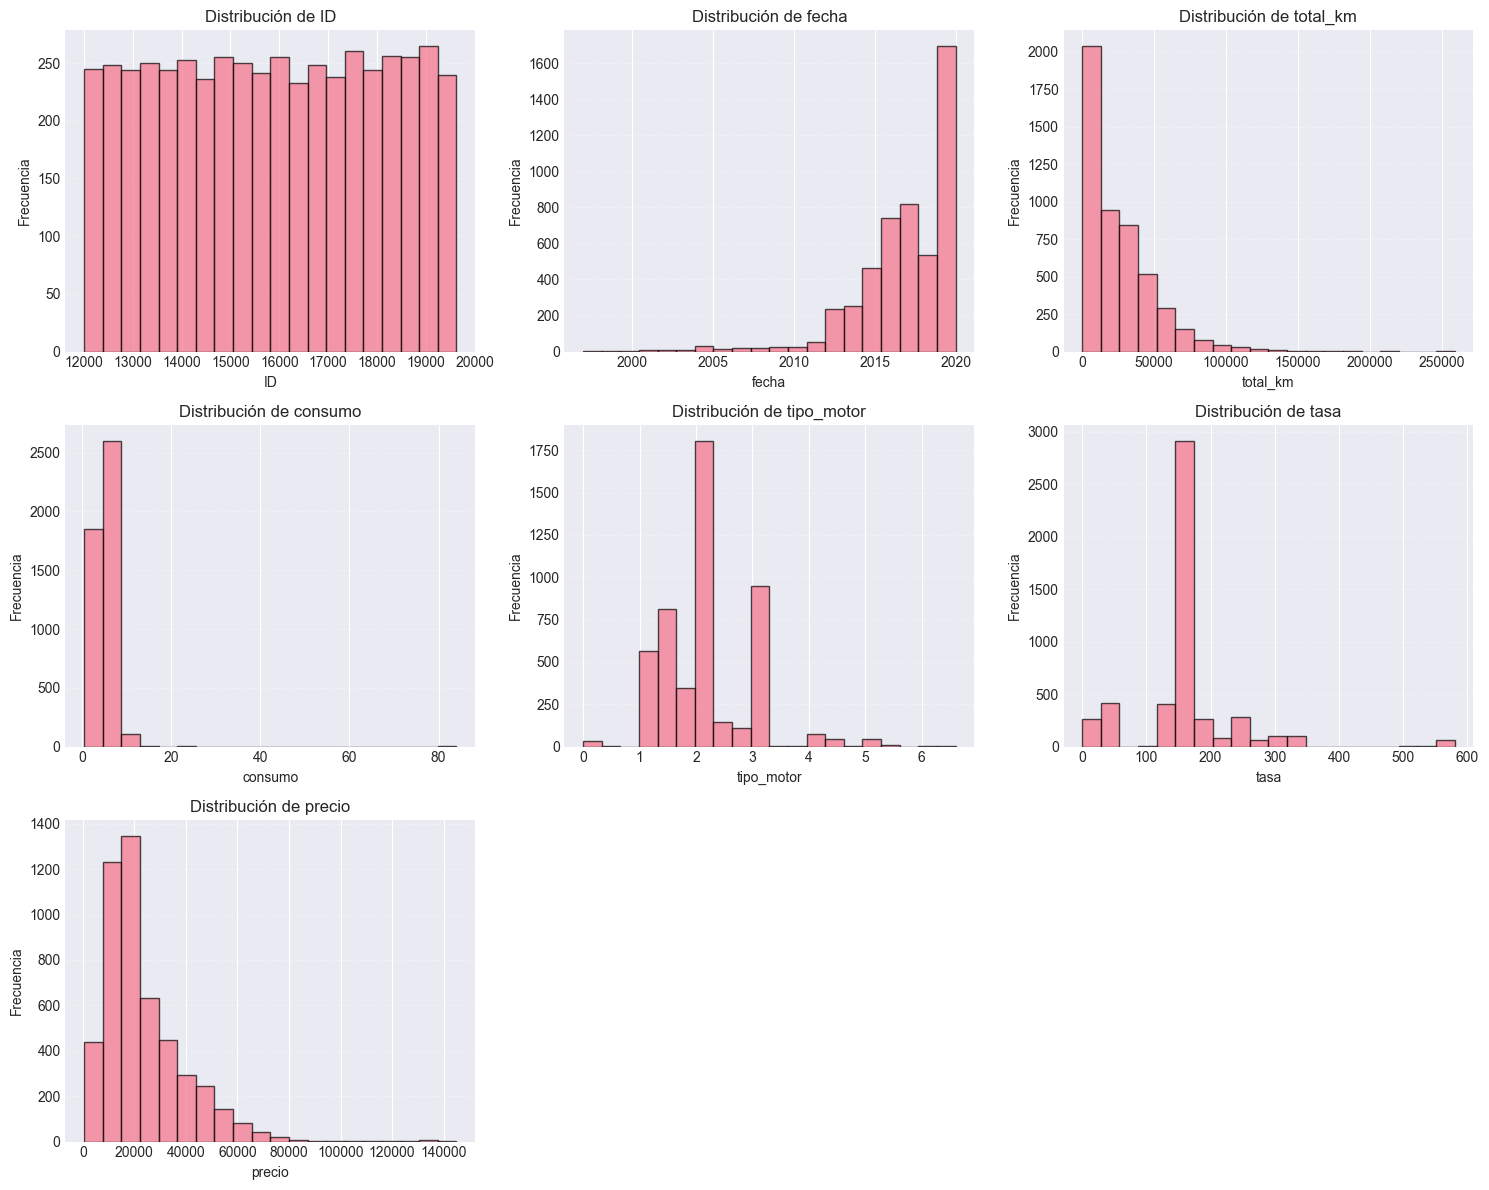

In [9]:
import math
#Número de columnas numéricas
n_cols = len(num_cols)

# Definir filas y columnas del subplot
n_rows = math.ceil(n_cols / 3)
n_cols_subplot = 3

fig, axes = plt.subplots(n_rows, n_cols_subplot, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Para iterar fácilmente

for i, col in enumerate(num_cols):
    axes[i].hist(
        train_data[col],
        bins=20,
        edgecolor='black',
        alpha=0.7
    )
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

# Eliminar subplots vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()





Para finalizar el análisis de estos datos, comprobemos la correlación entre la variable objetivo y las variables numéricas.


### 2.2 Analisis de correlación

Se calculó la matriz de correlación y se generó un mapa de calor de para visualizar e identificar de forma gráfica las relaciones entre las variables.


 Matriz de Correlación - Variables Numéricas


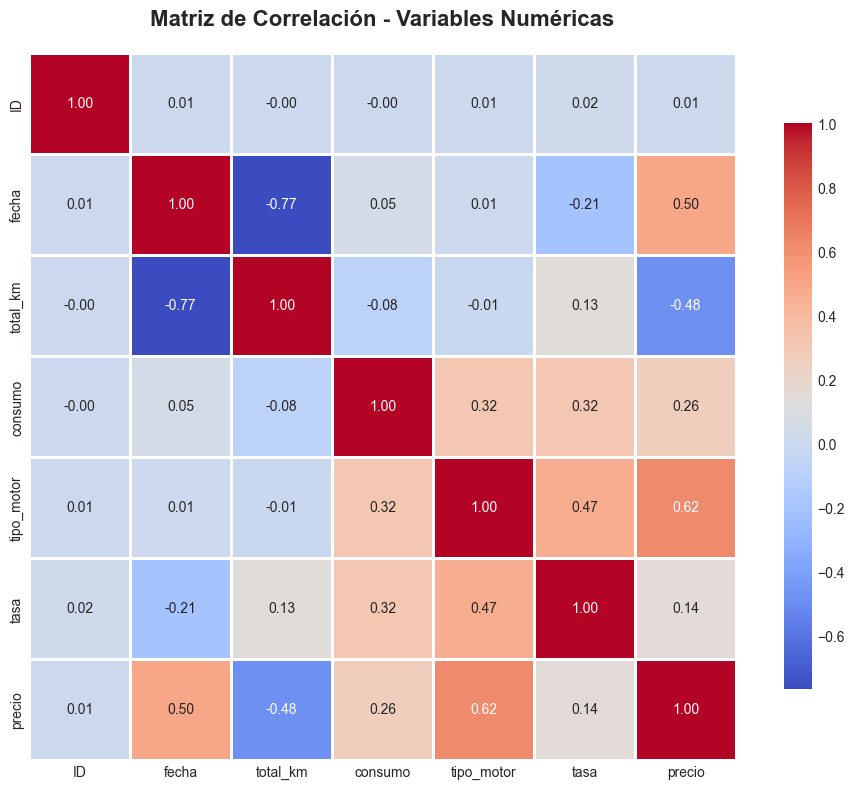


 Correlación con la variable objetivo (PRECIO):
precio        1.000000
tipo_motor    0.624899
fecha         0.501296
consumo       0.261857
tasa          0.144652
ID            0.012129
total_km     -0.478705
Name: precio, dtype: float64


In [10]:

# 5.1 Matriz de correlación entre variables numéricas

print("\n Matriz de Correlación - Variables Numéricas")

correlation_matrix = train_data[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


# 5.2 Correlación con la variable objetivo (Precio)
print("\n Correlación con la variable objetivo (PRECIO):")
correlaciones_precio = train_data[num_cols].corr()['precio'].sort_values(ascending=False)
print(correlaciones_precio)


El tipo de motor muestra una correlación positiva moderada con el precio (r = 0,62), lo que indica que vehículos con motores de mayor capacidad o potencia tienden a alcanzar precios más elevados. La fecha de fabricación presenta también una correlación positiva moderada (r = 0,50), evidenciando que los modelos más recientes conservan mayor valor de mercado. En contraste, el kilometraje total exhibe una correlación negativa moderada (r = −0,48), confirmando que un mayor uso reduce el precio del vehículo. Por su parte, el consumo presenta una correlación positiva débil (r = 0,26), mientras que la tasa muestra una relación aún más limitada (r = 0,14). Estos valores indican que su influencia individual sobre el precio es reducida. En conjunto, los coeficientes numéricos reflejan que las variables técnicas y de uso explican mejor la variabilidad del precio que los factores operativos secundarios.

Primero se transformó la variable 'fecha' en 'antiguedad ' calculando la diferencia entre el año actual y el año de fabricación, eliminando la columna original para evitar redundancia y mejorar la interpretabilidad del modelo."


 Precio promedio por MARCA:
                  mean   median  count
marca                                 
audi      42330.967930  39881.0    343
bmw       37623.815047  35480.0    638
merc      30308.413924  25913.0    790
vw        21792.028646  20392.0    768
toyota    18837.609865  17498.0    446
ford      15927.887728  16699.5    766
hyundi    14619.753425  11000.0    511
skoda     13858.767059  14950.0    425
vauxhall  11884.520147  12995.0    273


C:\Users\govan\AppData\Local\Temp\ipykernel_5836\1462238016.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, y='marca', x='precio',


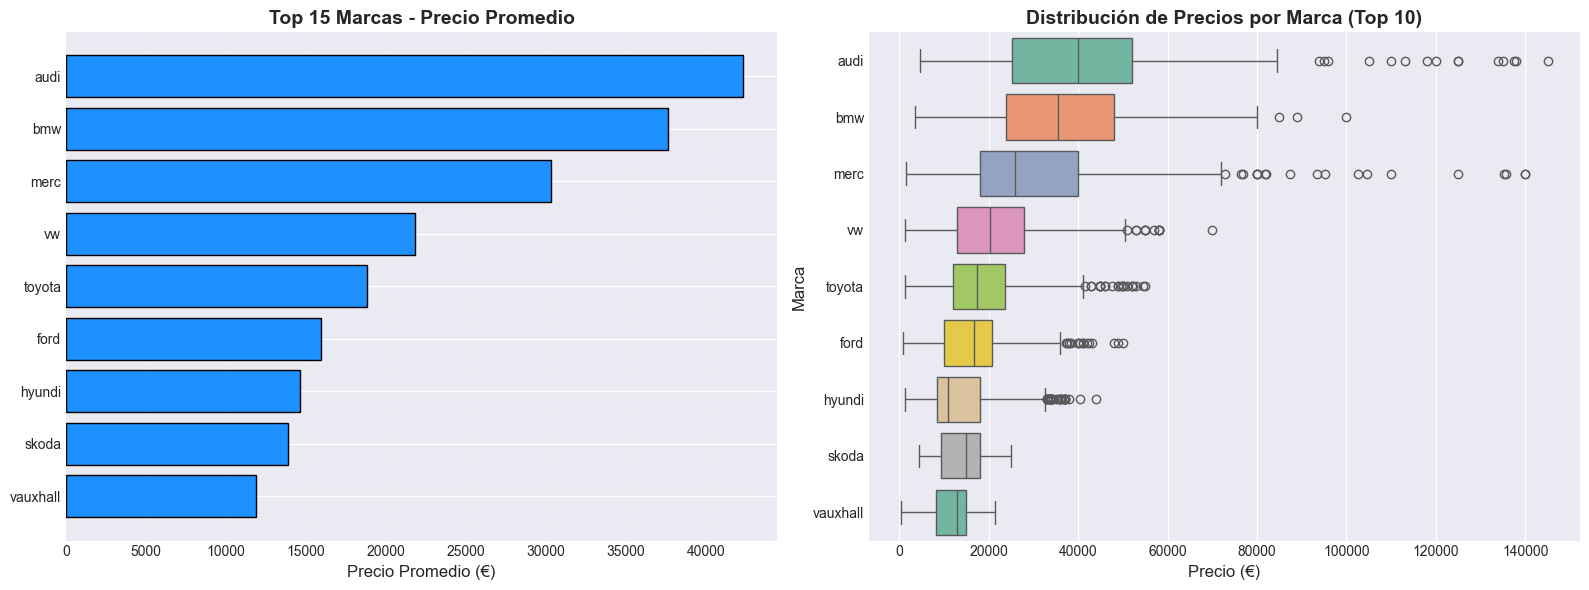

In [11]:
# comprobemos la correlación entre la variable objetivo y las variables categoricas como la marca 


# 6.1 Precio promedio por MARCA
print("\n Precio promedio por MARCA:")
precio_marca = train_data.groupby('marca')['precio'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(precio_marca.head(10))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de barras
top_marcas = precio_marca.head(15)
axes[0].barh(top_marcas.index, top_marcas['mean'], color='dodgerblue', edgecolor='black')
axes[0].set_xlabel('Precio Promedio (€)', fontsize=12)
axes[0].set_title('Top 15 Marcas - Precio Promedio', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.3)

# Boxplot
sns.boxplot(data=train_data, y='marca', x='precio', 
            order=precio_marca.head(10).index, ax=axes[1], palette='Set2')
axes[1].set_title('Distribución de Precios por Marca (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Precio (€)', fontsize=12)
axes[1].set_ylabel('Marca', fontsize=12)

plt.tight_layout()
plt.show()



El análisis exploratorio revela que la marca del vehículo es un factor determinante en la formación del precio. Las marcas del segmento premium, como Audi, BMW y Mercedes, presentan los precios promedio más elevados, así como una mayor variabilidad, reflejada en la presencia de numerosos valores atípicos asociados a modelos de alto rendimiento o lujo.

Por el contrario, las marcas generalistas y económicas como (Volkswagen, Skoda, Vauxhall) muestran distribuciones de precios más compactas y homogéneas, con menor dispersión y ausencia de valores extremos significativos. Esta segmentación evidencia que el mercado automotriz no sigue una estructura lineal uniforme, sino que está fuertemente condicionado por el posicionamiento de marca.

## 3. Procesamiento del dataset

In [12]:
# Guardar variable objetivo
y_train = train_data['precio'].copy()
y_test = test_data['precio'].copy()

# Separar datos
train_prep = train_data.drop('precio', axis=1).copy()
test_prep = test_data.drop('precio', axis=1).copy()


### a) Imputacion de valores nulos

In [13]:
# Imputar consumo con la media
mean_consumo_train = train_prep['consumo'].mean()
train_prep['consumo'] = train_prep['consumo'].fillna(mean_consumo_train)
test_prep['consumo'] = test_prep['consumo'].fillna(mean_consumo_train)

# Imputar tipo_cambio con la moda
top_cambio = train_prep['tipo_cambio'].value_counts().index[0]
train_prep['tipo_cambio'] = train_prep['tipo_cambio'].fillna(top_cambio)
test_prep['tipo_cambio'] = test_prep['tipo_cambio'].fillna(top_cambio)

print(" Valores nulos imputados")
print(f"   Nulos en train: {train_prep.isnull().sum().sum()}")
print(f"   Nulos en test: {test_prep.isnull().sum().sum()}")


 Valores nulos imputados
   Nulos en train: 0
   Nulos en test: 0


- Creacion de nuevas categorias

In [14]:
# Crear variable 'antigüedad'
current_year = date.today().year
train_prep['antiguedad'] = current_year - train_prep['fecha']
test_prep['antiguedad'] = current_year - test_prep['fecha']

# Eliminar columna fecha
train_prep = train_prep.drop('fecha', axis=1)
test_prep = test_prep.drop('fecha', axis=1)

print(" Variable 'antiguedad' creada")
print(f"   Rango antiguedad: {train_prep['antiguedad'].min()} - {train_prep['antiguedad'].max()} años")


 Variable 'antiguedad' creada
   Rango antiguedad: 6 - 29 años


### b ) Transformación de variables categóricas

Los modelos de Machine Learning solo procesan datos numéricos, por lo que las variables categóricas como marca, tipo de combustible o transmisión requieren transformación obligatoria para ser utilizadas

  

- Transformación Logaritmica (para variables asimétricas)

In [15]:

skewed_cols = ['total_km', 'consumo']
train_prep[skewed_cols] = np.log1p(train_prep[skewed_cols])

test_prep[skewed_cols] = np.log1p(test_prep[skewed_cols])

ENCODING DE VARIABLES CATEGÓRICAS (One-Hot Encoding)

In [16]:
#ENCODING DE VARIABLES CATEGÓRICAS (One-Hot Encoding)
print("\n Encoding de variables categóricas (One-Hot Encoding)...")

cat_features = ['marca', 'modelo', 'tipo_combustible', 'tipo_cambio']

encoder = OneHotEncoder(sparse_output=False, min_frequency=0.05, handle_unknown='infrequent_if_exist')

train_encoded = encoder.fit_transform(train_prep[cat_features])

test_encoded = encoder.transform(test_prep[cat_features])

train_encoded_df = pd.DataFrame(
    train_encoded, 
    columns=encoder.get_feature_names_out(cat_features),
    index=train_prep.index)

test_encoded_df = pd.DataFrame(
    test_encoded,
    columns=encoder.get_feature_names_out(cat_features), 
    index=test_prep.index)

print(" Variables categóricas codificadas")
print(train_encoded_df.head())
print(f"Nuevas columnas creadas: {train_encoded_df.shape[1]}")


 Encoding de variables categóricas (One-Hot Encoding)...
 Variables categóricas codificadas
   marca_audi  marca_bmw  marca_ford  marca_hyundi  marca_merc  marca_skoda  marca_toyota  marca_vauxhall  marca_vw  modelo_infrequent_sklearn  tipo_combustible_Diesel  tipo_combustible_Petrol  tipo_combustible_infrequent_sklearn  tipo_cambio_Automatic  tipo_cambio_Manual  tipo_cambio_Semi-Auto  tipo_cambio_infrequent_sklearn
0         0.0        0.0         0.0           1.0         0.0          0.0           0.0             0.0       0.0                        1.0                      1.0                      0.0                                  0.0                    0.0                 0.0                    1.0                             0.0
1         0.0        0.0         0.0           0.0         0.0          0.0           0.0             1.0       0.0                        1.0                      1.0                      0.0                                  0.0                    0.

### c) Normalizar variables numéricas

In [17]:
#  ESCALADO DE VARIABLES NUMÉRICAS
print("\n Escalado de variables numéricas (StandardScaler)...")

num_features = ['total_km', 'consumo', 'tipo_motor', 'tasa', 'antiguedad']

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_prep[num_features])
test_scaled = scaler.transform(test_prep[num_features])

train_scaled_df = pd.DataFrame(train_scaled, columns=num_features, index=train_prep.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=num_features, index=test_prep.index)

print(" Variables numéricas escaladas")
print(train_scaled_df.head())
print(f"   Medias del scaler: {scaler.mean_}")
print(f"   Desviaciones estándar: {scaler.scale_}")


 Escalado de variables numéricas (StandardScaler)...
 Variables numéricas escaladas
   total_km   consumo  tipo_motor      tasa  antiguedad
0 -0.553942  0.454014    0.095814 -0.088993   -0.784430
1  0.806819 -0.854714   -0.157579 -0.331725    0.602655
2 -0.442624  1.500031    0.982689 -0.088993   -0.784430
3  0.329379 -0.724348   -0.157579 -1.484700    0.255884
4 -0.648229 -0.093224   -1.424542 -0.088993   -1.131202
   Medias del scaler: [  9.33682311   1.81443117   2.124375   152.33266129   9.26209677]
   Desviaciones estándar: [ 1.78409567  0.26108992  0.78928856 82.39553639  2.88374456]


### 4. Unión de datasets procesados

In [18]:
X_train = pd.concat([train_scaled_df, train_encoded_df], axis=1)

X_test = pd.concat([test_scaled_df, test_encoded_df], axis=1)

print("\n PREPROCESAMIENTO COMPLETADO")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")


 PREPROCESAMIENTO COMPLETADO
   X_train shape: (4960, 22)
   X_test shape: (2672, 22)
   y_train shape: (4960,)
   y_test shape: (2672,)


## 5. Entrenamiento de modelos

### Regresion lineal



In [ ]:
# Diccionario para guardar resultados
resultados = {}

print("\n Entrenando Regresión Lineal")
#Creamos el modelo de Regresión Lineal
lr = LinearRegression()
#entrenamos el modelo
lr.fit(X_train, y_train)

# Realizamos predicciones
y_pred_lr = lr.predict(X_test)




 Entrenando Regresión Lineal


Tras esto, ahora ya sí podemos empezar a modelizar! Comencemos con el problema de regresión utilizando la regresión lineal.

### 1. Regresion Lineal

In [20]:
# Evaluamos el modelo

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

resultados['Regresión Lineal'] = {
    'MAE': mae_lr,
    'MAPE': mape_lr,
    'RMSE': rmse_lr,
    'R2': r2_lr,
    'predicciones': y_pred_lr
}

print(f"✅ Regresión Lineal completada")
print(f"   MAE: {mae_lr:,.2f} €")
print(f"   MAPE: {mape_lr:.2%}")
print(f"   RMSE: {rmse_lr:,.2f} €")
print(f"   R²: {r2_lr:.4f}")


✅ Regresión Lineal completada
   MAE: 5,481.36 €
   MAPE: 32.49%
   RMSE: 8,708.46 €
   R²: 0.7247


El MAE de 5.481,36 € muestra que, en promedio, las predicciones se desvían alrededor de cinco mil euros respecto al valor real. El MAPE del 32,49 % sugiere un error relativo moderado, indicando que aún existe variabilidad no capturada por el modelo en algunos rangos de precio. El RMSE de 8.708,46 €, al penalizar más los errores grandes, revela la presencia de predicciones con desviaciones elevadas. 

In [21]:

# Predicciones sobre el conjunto de test
preds_reg = lr.predict(X_test)
# Redondear a 2 decimales
preds_reg_2dec = np.round(preds_reg, 2)

# Mostrar resultados
print('Primeras 5 predicciones: ', preds_reg_2dec[:5])
print('Targets reales: ', y_test.values[:5])

Primeras 5 predicciones:  [37536.76 27588.57 43001.26 14332.74 45325.84]
Targets reales:  [38000 23495 59999 16713 46000]


Se analizaron las primeras cinco predicciones del modelo de regresión lineal frente a los valores reales de precios de vehículos usados. Las predicciones mostraron buena aproximación en valores medianos, por ejemplo, 37,536 € frente a 38,000 €. Sin embargo, se observan desviaciones importantes en precios altos, como 43,000 € frente a 59,999 €, indicando limitaciones del modelo lineal. Esto sugiere que el modelo predice con mayor precisión rangos intermedios, pero tiene dificultades con valores extremos. 

### Árbol de decisión

In [22]:
# Entrenando Árbol de Decisión
dt = DecisionTreeRegressor (max_depth=15, min_samples_split=10, min_samples_leaf=5, random_state=42)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Calcular métricas
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# Guardar resultados
resultados['Árbol de Decisión'] = {
    'MAE': mae_dt,
    'MAPE': mape_dt,
    'RMSE': rmse_dt,
    'R2': r2_dt,
    'predicciones': y_pred_dt
}

print('Regresión')
print('-'*10)
print(f" Árbol de Decisión completado")
print(f"   MAE: {mae_dt:,.2f} €")
print(f"   MAPE: {mape_dt:.2%}")
print(f"   RMSE: {rmse_dt:,.2f} €")
print(f"   R²: {r2_dt:.4f}")



Regresión
----------
 Árbol de Decisión completado
   MAE: 2,998.36 €
   MAPE: 13.70%
   RMSE: 6,023.14 €
   R²: 0.8683


## 6. Combinación de modelos

En ocasiones combinar diferentes modelos, especialmente si son diferentes, puede mejorar el resultado de cada uno de ellos.

### Random Forest

In [23]:
# Entrenando Random Forest

rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, 
                           min_samples_leaf=2, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Guardar resultados
resultados['Random Forest'] = {
    'MAE': mae_rf,
    'MAPE': mape_rf,
    'RMSE': rmse_rf,
    'R2': r2_rf,
    'predicciones': y_pred_rf
}

print(f" Random Forest ")
print(f"   MAE: {mae_rf:,.2f} €")
print(f"   MAPE: {mape_rf:.2%}")
print(f"   RMSE: {rmse_rf:,.2f} €")
print(f"   R²: {r2_rf:.4f}")

 Random Forest 
   MAE: 2,295.07 €
   MAPE: 10.98%
   RMSE: 4,157.71 €
   R²: 0.9372


### Gradient Boosting

In [24]:
print("\n Entrenando Gradient Boosting...")

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, 
                               min_samples_split=5, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

resultados['Gradient Boosting'] = {
    'MAE': mae_gb,
    'MAPE': mape_gb,
    'RMSE': rmse_gb,
    'R2': r2_gb,
    'predicciones': y_pred_gb
}

print(f" Gradient Boosting completado")
print(f"   MAE: {mae_gb:,.2f} €")
print(f"   MAPE: {mape_gb:.2%}")
print(f"   RMSE: {rmse_gb:,.2f} €")
print(f"   R²: {r2_gb:.4f}")


 Entrenando Gradient Boosting...
 Gradient Boosting completado
   MAE: 2,508.37 €
   MAPE: 13.15%
   RMSE: 4,244.10 €
   R²: 0.9346


### 7. COMPARACIÓN DE MODELOS


 TABLA COMPARATIVA DE MODELOS:
                           MAE      MAPE         RMSE        R2
Random Forest      2295.074658  0.109828  4157.706247   0.93725
Gradient Boosting  2508.369958  0.131457  4244.102544  0.934615
Árbol de Decisión  2998.361552  0.137007  6023.144417   0.86831
Regresión Lineal   5481.363343  0.324908  8708.459609   0.72471


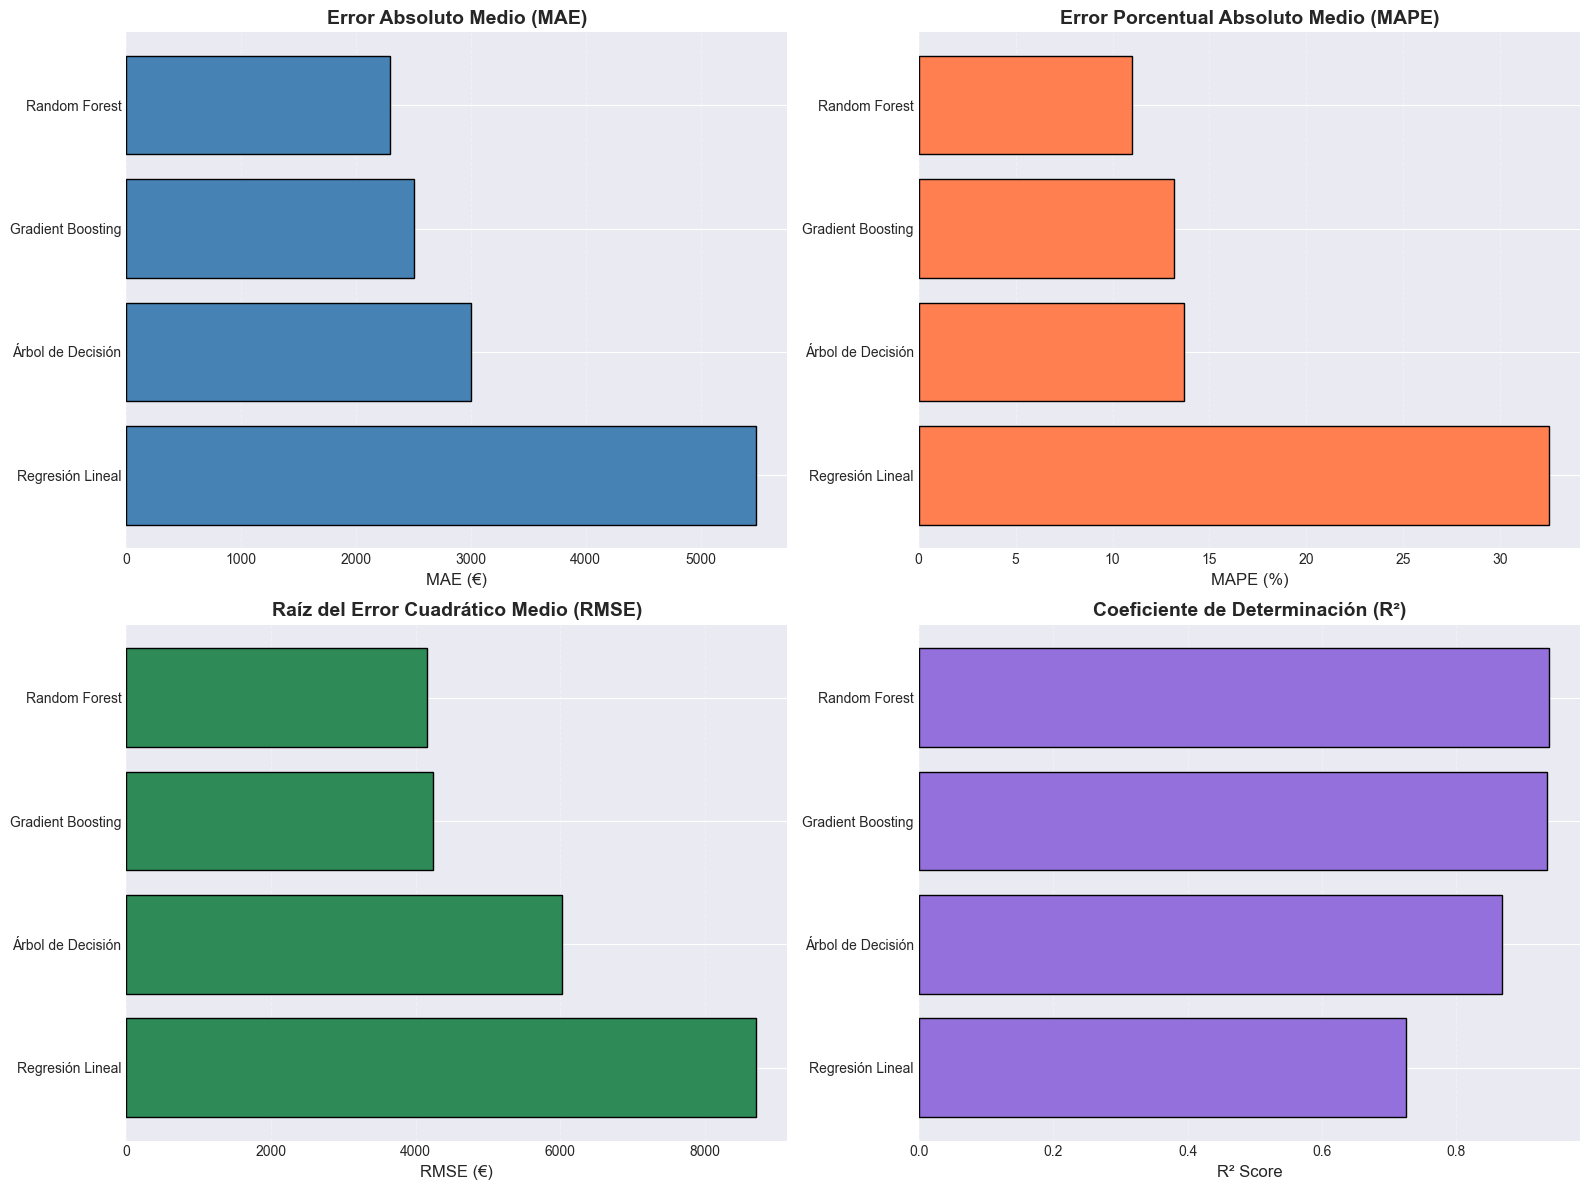

In [25]:
# Crear DataFrame de comparación
comparacion_df = pd.DataFrame(resultados).T
comparacion_df = comparacion_df.drop('predicciones', axis=1)
comparacion_df = comparacion_df.sort_values('MAE')

print("\n TABLA COMPARATIVA DE MODELOS:")
print(comparacion_df.to_string())

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE
axes[0, 0].barh(comparacion_df.index, comparacion_df['MAE'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('MAE (€)', fontsize=12)
axes[0, 0].set_title('Error Absoluto Medio (MAE)', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.3)

# MAPE
axes[0, 1].barh(comparacion_df.index, comparacion_df['MAPE']*100, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('MAPE (%)', fontsize=12)
axes[0, 1].set_title('Error Porcentual Absoluto Medio (MAPE)', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.3)

# RMSE
axes[1, 0].barh(comparacion_df.index, comparacion_df['RMSE'], color='seagreen', edgecolor='black')
axes[1, 0].set_xlabel('RMSE (€)', fontsize=12)
axes[1, 0].set_title('Raíz del Error Cuadrático Medio (RMSE)', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.3)

# R²
axes[1, 1].barh(comparacion_df.index, comparacion_df['R2'], color='mediumpurple', edgecolor='black')
axes[1, 1].set_xlabel('R² Score', fontsize=12)
axes[1, 1].set_title('Coeficiente de Determinación (R²)', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
# Identificar mejor modelo
mejor_modelo_nombre = comparacion_df['MAE'].idxmin()
print(f"\n MEJOR MODELO: {mejor_modelo_nombre}")
print(f"   MAE: {comparacion_df.loc[mejor_modelo_nombre, 'MAE']:,.2f} €")
print(f"   MAPE: {comparacion_df.loc[mejor_modelo_nombre, 'MAPE']:.2%}")
print(f"   R²: {comparacion_df.loc[mejor_modelo_nombre, 'R2']:.4f}")



 MEJOR MODELO: Random Forest
   MAE: 2,295.07 €
   MAPE: 10.98%
   R²: 0.9372


La Random Forest es el modelo con mejor rendimiento, con el menor MAE (2.295 €), MAPE más bajo (10,98 %) y el mayor R² (0,937), lo que indica una alta precisión y gran capacidad explicativa.
El Gradient Boosting presenta resultados muy similares, con errores ligeramente mayores y un R² de 0,935, consolidándose como una alternativa robusta.
El Árbol de Decisión muestra un desempeño intermedio, con mayor error y menor estabilidad, reflejado en un RMSE de 6.023 €.
La Regresión Lineal es el modelo con peor ajuste, con errores significativamente más altos y un R² de 0,725, lo que indica una limitada capacidad para capturar relaciones complejas.
En conjunto, los modelos basados en ensembles superan claramente a los modelos simples en la predicción del precio.

### 8. Análisis del mejor modelo

In [27]:

print("\n" + "="*80)
print(f"ANÁLISIS DETALLADO DEL MEJOR MODELO: {mejor_modelo_nombre}")
print("="*80)

# Usar Random Forest como mejor modelo
mejor_modelo = rf
y_pred_mejor = y_pred_rf


ANÁLISIS DETALLADO DEL MEJOR MODELO: Random Forest


Pregunta 4. Analizar las variables más significativas, ya sea mediante un test 
estadístico o analizando el modelo entrenado. 


 Importancia de las características:

 Top 10 variables más importantes:
               feature  importance
2           tipo_motor    0.481145
4           antiguedad    0.212507
0             total_km    0.123802
1              consumo    0.087227
3                 tasa    0.020669
6            marca_bmw    0.016132
19  tipo_cambio_Manual    0.011522
9           marca_merc    0.011294
7           marca_ford    0.009528
5           marca_audi    0.007466


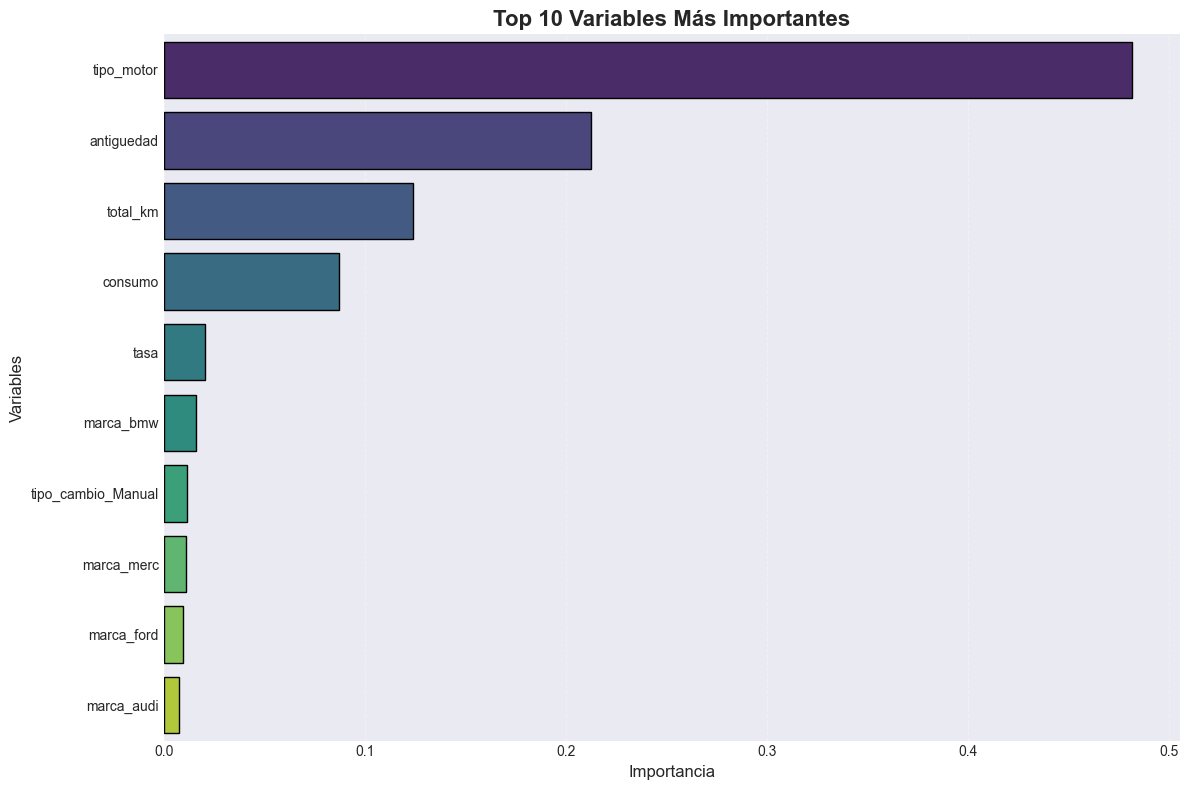

In [28]:
# 10 . IMPORTANCIA DE CARACTERÍSTICAS
print("\n Importancia de las características:")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': mejor_modelo.feature_importances_
}).sort_values('importance', ascending=False)
print("\n Top 10 variables más importantes:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance',hue='feature', 
            palette='viridis', edgecolor='black',legend=False)
plt.title('Top 10 Variables Más Importantes', fontsize=16, fontweight='bold')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


📈 Análisis de predicciones vs valores reales:


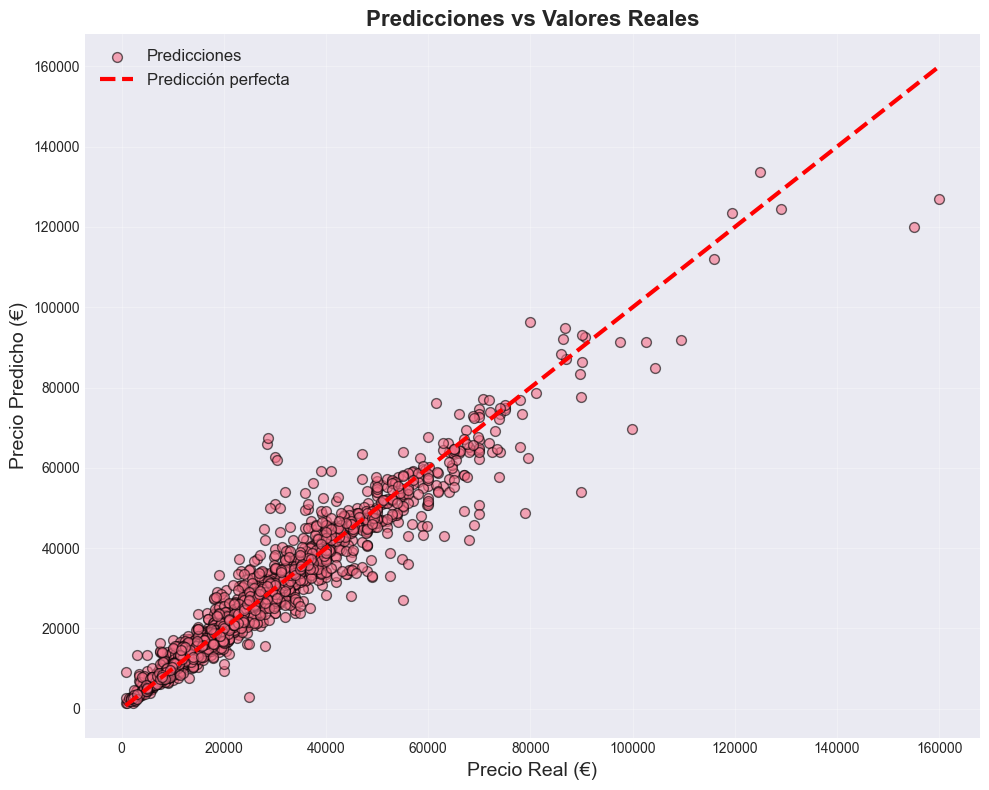

In [29]:
print("\n📈 Análisis de predicciones vs valores reales:")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_mejor, alpha=0.6, edgecolor='black', s=50, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Predicción perfecta')
plt.xlabel('Precio Real (€)', fontsize=14)
plt.ylabel('Precio Predicho (€)', fontsize=14)
plt.title('Predicciones vs Valores Reales', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Preguntas del Ejercicio

Pregunta 1. Representar gráficamente la distribución de la variable precio en el 
conjunto de entrenamiento. 

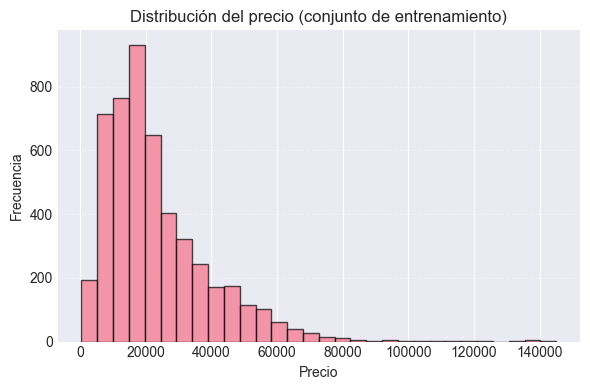

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(train_data['precio'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución del precio (conjunto de entrenamiento)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Pregunta 2. ¿Cuál es la marca más cara y la más barata en promedio? (train)

In [31]:
# Precio promedio por marca
precio_medio_marca = train_data.groupby('marca')['precio'].mean().sort_values()

# Marca más barata y más cara
marca_mas_barata = precio_medio_marca.index[0]
precio_mas_barato = precio_medio_marca.iloc[0]

marca_mas_cara = precio_medio_marca.index[-1]
precio_mas_caro = precio_medio_marca.iloc[-1]

print("Marca más barata en promedio:", marca_mas_barata, "-", round(precio_mas_barato, 2))
print("Marca más cara en promedio:", marca_mas_cara, "-", round(precio_mas_caro, 2))

Marca más barata en promedio: vauxhall - 11884.52
Marca más cara en promedio: audi - 42330.97


Pregunta 3. Representar gráficamente la dependencia entre el precio y la fecha. 
Utilice el conjunto de entrenamiento.

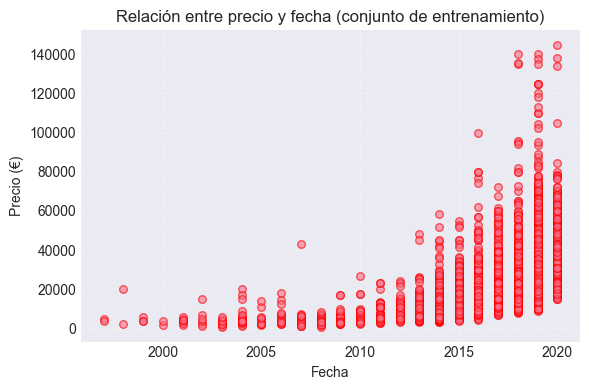

In [32]:
plt.figure(figsize=(6, 4))
plt.scatter(train_data['fecha'], train_data['precio'], alpha=0.6,edgecolor='red', s=30)
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.title('Relación entre precio y fecha (conjunto de entrenamiento)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Pregunta 4. Analizar las variables más significativas, ya sea mediante un test 
estadístico o analizando el modelo entrenado. 

In [33]:

# Usar Random Forest como mejor modelo
mejor_modelo = rf
y_pred_mejor = y_pred_rf


 Importancia de las características:

 Top 10 variables más importantes:
               feature  importance
2           tipo_motor    0.481145
4           antiguedad    0.212507
0             total_km    0.123802
1              consumo    0.087227
3                 tasa    0.020669
6            marca_bmw    0.016132
19  tipo_cambio_Manual    0.011522
9           marca_merc    0.011294
7           marca_ford    0.009528
5           marca_audi    0.007466


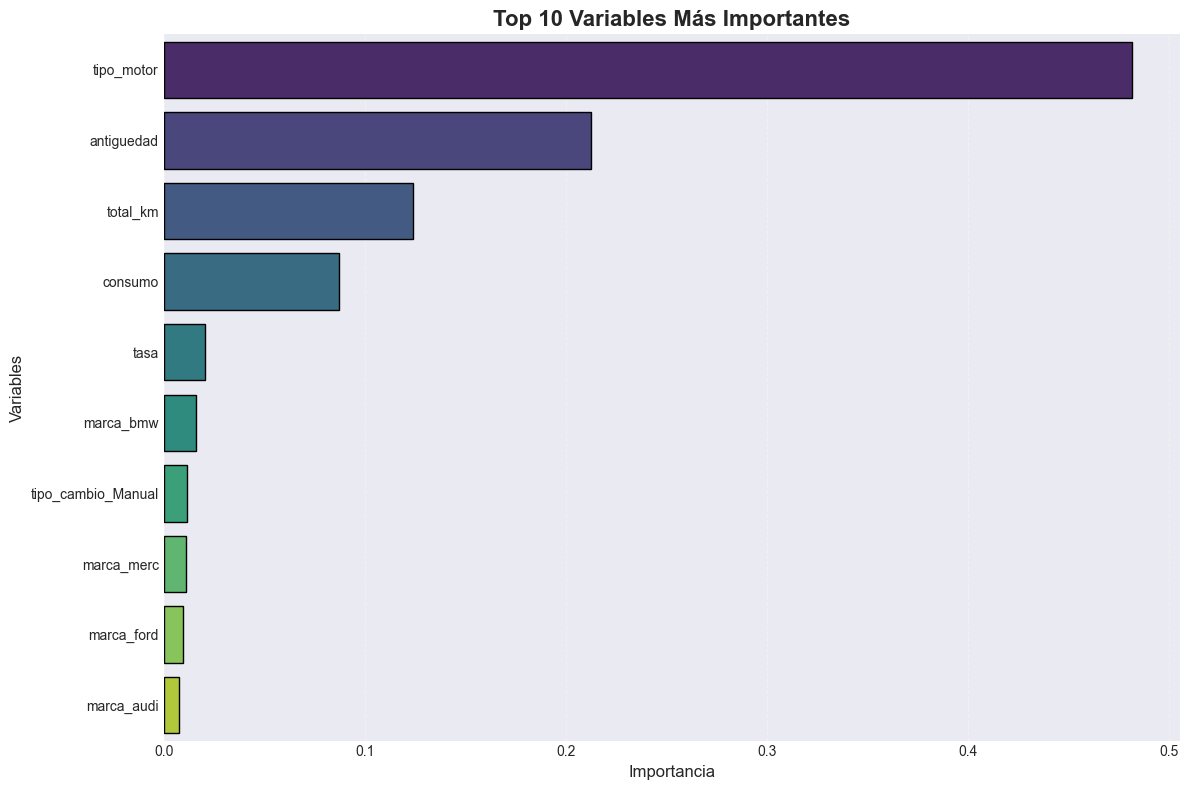

In [34]:
#  IMPORTANCIA DE CARACTERÍSTICAS
print("\n Importancia de las características:")

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': mejor_modelo.feature_importances_
}).sort_values('importance', ascending=False)
print("\n Top 10 variables más importantes:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='importance',hue='feature', 
            palette='viridis', edgecolor='black',legend=False)
plt.title('Top 10 Variables Más Importantes', fontsize=16, fontweight='bold')
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Pregunta 5. Un amigo quiere vender un audi A7 de 2020 con 5000 km, cambio 
automático, combustible híbrido, consumo de 5.5 l/100km y motor 4.0. Su tasa 
de circulación es de 200€. ¿A cuánto debería venderlo? 


In [35]:
import pandas as pd
import numpy as np
from joblib import load

# 1. Cargamos el modelo y los transformadores
modelo_cargado = load('modelo_precios_coches.joblib')
scaler_cargado = load('scaler.joblib')
encoder_cargado = load('encoder.joblib')

def predecir_precio_amigo(datos_coche):
    # Convertimos los datos a un DataFrame
    df_amigo = pd.DataFrame([datos_coche])
    
    # --- PROCESAMIENTO IGUAL AL ENTRENAMIENTO ---
    
    # A. Crear variable 'antiguedad' (suponiendo current_year = 2026 o el que usaste)
    from datetime import date
    current_year = date.today().year
    df_amigo['antiguedad'] = current_year - df_amigo['fecha']
    
    # B. Aplicar Logaritmo a las columnas que definiste como skewed
    # Nota: Asegúrate de que los nombres coincidan con los de tu entrenamiento
    df_amigo['total_km'] = np.log1p(df_amigo['total_km'])
    df_amigo['consumo'] = np.log1p(df_amigo['consumo'])
    
    # C. Encoding de variables categóricas
    cat_cols = ['marca', 'modelo', 'tipo_combustible', 'tipo_cambio']
    encoded_amigo = encoder_cargado.transform(df_amigo[cat_cols])
    encoded_df_amigo = pd.DataFrame(encoded_amigo, 
                                    columns=encoder_cargado.get_feature_names_out(cat_cols))
    
    # D. Escalado de variables numéricas
    num_cols = ["total_km", "consumo", "tipo_motor", "tasa", "antiguedad"]
    scaled_amigo = scaler_cargado.transform(df_amigo[num_cols])
    scaled_df_amigo = pd.DataFrame(scaled_amigo, columns=num_cols)
    
    # E. Concatenar para formar el vector de entrada X
    X_amigo = pd.concat([scaled_df_amigo, encoded_df_amigo], axis=1)
    
    # 2. PREDICCIÓN
    precio_predicho = modelo_cargado.predict(X_amigo)
    return precio_predicho[0]

# --- DATOS DEL AMIGO ---
datos_amigo = {
    'marca': 'audi',
    'modelo': 'A7',  # Si el modelo 'A7' no estaba en el top frecuente, el encoder lo tratará como 'infrequent'
    'fecha': 2020,
    'total_km': 5000,
    'tipo_cambio': 'Automatic',
    'tipo_combustible': 'Hybrid',
    'consumo': 5.5,
    'tipo_motor': 4.0,
    'tasa': 200
}

# Ejecutar predicción
resultado = predecir_precio_amigo(datos_amigo)
print(f"El precio recomendado de venta para el Audi A7 es de: {resultado:.2f} €")

El precio recomendado de venta para el Audi A7 es de: 67329.19 €
